# Измерение звездного фона и коэффициента его ослабления фильтрами

    Место измерений п.Научный КрАО.
    Измерения проводились в период 21:42 по 23:08 08.11.2018.
    В поле зрения прибора визуально наблюдался Млечный путь.
    Код питающего напряжения - 250. U1=-26.8В, U2=+2.05В (Общее ~28,8В).

    No.|~время |Назначение
    1 21:42 Без фильтров
    2 21:50 УФС-1
    3 21:56 Без фильтров
    4 22:02 УФС-5
    5 22:07 Без фильтров
    6 22:13 ФС6 (BG3)
    7 22:18 Без фильтров
    8 22:25 SL360\50
    9 22:30 Без фильтров
    10 22:35 SL280-380
    11 22:40 Без фильтров
    12 22:46 FF01-375/110
    13 22:56 Без фильтров
    14 23:04 С закрытой диафрагмой (собственный тепловой шум SiPM, пьедестал)


Сбой в записи в файл 08.11.2018   с  20:08:33 по 20:19:05  и  с  21:30:40 по 21:37:32, что не входит во временной интервал измерений.

In [1]:
!date
!pwd
#/home/sphere/ExpData/Program/Sketch/Data

Чт ноя 15 20:26:29 MSK 2018
/home/sphere/ExpData/Program/Sketch/Data


In [2]:
import pandas as pd
import numpy as np

## Чтение файла данных

In [3]:
## ['date', 'time', 'On', 'u', 'i', 't', 'u5', 'dac', 'CH0', 'CH1', 'CH2', 'CH3', 'U']
dtype = {'date': str, 'time': str, 'On': str, 'u': str, 'i': str, 't': str, 'u5': str, 'dac': str,
         'CH0': np.uint8, 'CH1': np.uint8, 'CH2': np.uint8, 'CH3': np.uint8}

In [5]:
"""  Читаем файл с логами """
#data = pd.read_csv("data_measurements.txt", index_col=False, sep='\\s+',usecols=dtype.keys(), dtype=dtype)
data = pd.read_csv("data_measurements_1.txt", index_col=False, sep='\\s+')
data = data.drop(columns = "adc")

## reject lines with no data 
data = data[~data.On.isin(['OFF'])]
data = data[~data.date.isin(['OK','>','Recv','ADC_on:','DAC_write', 'ADC_off:','SEND','Start'])] #,'Input:'])]
data = data[~data.date.str.contains(r'AT+')]
data = data[~data.date.str.contains(r'SEN')]
data = data[data.date > '07.11.2018']

## add columns
data["U"]  = data.CH0 * 0.01528 - 36.91
data["I"]  = (4094.0 - data.CH1)/10.372
data["U5"] = (data.CH2 + 20.0)*0.01
data["T"]  = (data.CH3/2.0 - 500) * 0.1
#data['timestamp'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['time'])

## save data file
print(data.shape)
data.to_csv("data_input.csv")

data.drop(columns=['On', 'u', 'i', 't', 'u5', 'dac'], inplace = True)
data.head()
#data.describe()

(3041, 16)


,date,time,CH0,CH1,CH2,CH3,U,I,U5,T
0,Input:,21:c+measurements_begin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Input:,18:c+without+filters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,Input:,2:n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,08.11.2018,21:42:10,1439.0,4094.0,474.0,1145.0,-14.92208,0.0,4.94,7.25
73,08.11.2018,21:42:11,1440.0,4094.0,474.0,1145.0,-14.90680,0.0,4.94,7.25


## Таблица для результатов

In [4]:
""" Читаем файл расписания с временами и напряжениями """
table = pd.read_csv("table1.csv", index_col=False)
print(table.shape)
#table

(18, 6)


In [6]:
table['count'] = [0] * table.shape[0]
for i in range(table.shape[0]):
    part=data[(data.time >= table.begin[i]) & (data.time <= table.end[i])]
    #print(i, part.U.count(), part.U.mean(), sep='\t')
    table.loc[i, 'count'] = part.U.count()
    table.loc[i, 'U']     = part.U.mean()
    table.loc[i, 'Ustd'] = part.U.std()
    table.loc[i, 'I']    = part.I.mean()
    table.loc[i, 'Istd'] = part.I.std()
    table.loc[i, 'T']    = part['T'].mean()
    table.loc[i, 'Tstd'] = part['T'].std()
    table.loc[i, 'U5']   = part.U5.mean()
    table.loc[i, 'U5std'] = part.U5.std()
    table.loc[i, 'index0'] = part.index[0]
    table.loc[i, 'index1'] = part.index[part.U.count()-1]
    #print(i, part.index[0], part.index[part.U.count()-1])
    #if i== 3:
        #print(part)

Таблица характеристик серий измерений

    name      --- комментарий к серии измерений
    w         --- код DAC высокого напряжения
    begin     --- время начала периода измерений
    end       --- время окончания периода измерений
    count     --- количество измерений (секунд)
    U, Ustd   --- среднее и станд. отклонение напряжения источника  
    I, Istd   --- то же для тока SiPM
    T, Tstd   --- то же для температуры
    U5, U5std --- то же для напряжения 5В

In [7]:
table.drop(columns = ['N', 'time'])

,name,w,begin,end,count,U,Ustd,I,Istd,T,Tstd,U5,U5std,index0,index1
0,Без_фильтров,0,21:42:10,21:42:22,13,-14.905625,0.011606,0.037082,0.062711,7.215385,0.031521,4.941538,0.003755,72.0,84.0
1,Без_фильтров,230,21:42:23,21:42:43,20,-25.164264,0.007184,17.942538,0.168161,7.225000,0.025649,4.941000,0.003078,91.0,110.0
2,Без_фильтров,250,21:42:44,21:45:04,136,-26.767114,0.006394,37.688432,0.200830,7.245588,0.024699,4.940147,0.002103,117.0,252.0
3,УФС-1,250,21:50:29,21:53:54,199,-26.766691,0.005967,12.055554,0.144973,7.441960,0.043353,4.942915,0.004556,326.0,529.0
4,Без_фильтров,250,21:56:27,21:58:45,134,-26.766817,0.005881,38.019265,0.201319,7.443284,0.030529,4.941119,0.003609,689.0,827.0
5,УФС-5,250,22:02:53,22:05:35,157,-26.766221,0.005321,9.686785,0.128502,7.369108,0.050171,4.942739,0.004474,1078.0,1239.0
6,Без_фильтров,250,22:07:40,22:10:53,187,-26.767103,0.006104,37.986888,0.216050,7.264973,0.028215,4.940856,0.003165,1371.0,1561.0
7,ФС6_(BG3),250,22:13:13,22:16:29,190,-26.766573,0.005661,17.035744,0.150788,7.280000,0.040434,4.940526,0.002464,1708.0,1903.0
8,Без_фильтров,250,22:18:45,22:21:14,144,-26.765990,0.005383,38.444852,0.217986,7.174306,0.041386,4.941944,0.003972,2047.0,2193.0
9,SL360/50,250,22:25:08,22:28:23,189,-26.766748,0.005816,1.548736,0.091476,7.894444,0.129989,4.944233,0.004954,2429.0,2622.0


## Визуализация данных

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import dates
import datetime as dt

plt.rcParams['figure.figsize'] =(10,6)
plt.rcParams['lines.markersize'] = 5
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 12

In [9]:
print('Напряжение 5В стабильно.')
print('Разброс напряжения: {:.3f} +- {:.3f}'.format( table.U5.mean(), 0.5*(table.U5.max()-table.U5.min()) ) )

Напряжение 5В стабильно.
Разброс напряжения: 4.941 +- 0.002


In [10]:
def draw_parameter(param, yaxislabel = 'I, uA'):
    plt.figure(figsize = (10,6))
    x = table.U[(table.name == 'Без_фильтров') & (table.w > 10)]
    y = table[param][(table.name == 'Без_фильтров') & (table.w > 10)]
    plt.plot(x, y, '*', label = 'Без_фильтров', markersize = 10)
    x = table.U[table.name == 'С_закрытой_диафрагмой']
    y = table[param][table.name == 'С_закрытой_диафрагмой']
    plt.plot(x, y, 'o', label = 'С_закрытой_диафрагмой', markersize = 10)
    for i in ['УФС-1', 'УФС-5', 'ФС6_(BG3)', 'SL360\50', 'SL280-380','FF01-375/110']:
        x = table.U[table.name == i]
        y = table[param][table.name == i]
        plt.plot(x, y, '>', label= i, markersize = 10)
    plt.xlabel( 'U, V')
    plt.ylabel( yaxislabel)
    plt.legend()
    plt.grid()

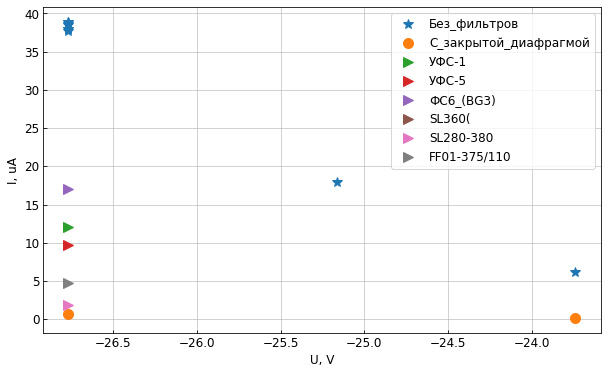

In [11]:
""" график токов """ 
draw_parameter('I')

### Температура

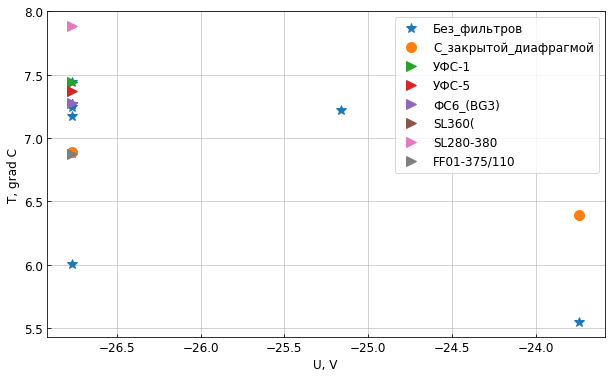

In [12]:
""" график температур """ 
draw_parameter('T', 'T, grad C')

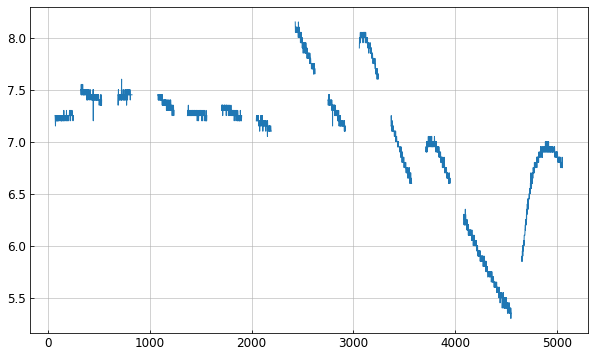

In [13]:
""" график температур посекундный """ 
plt.plot(data['T'])
plt.grid()

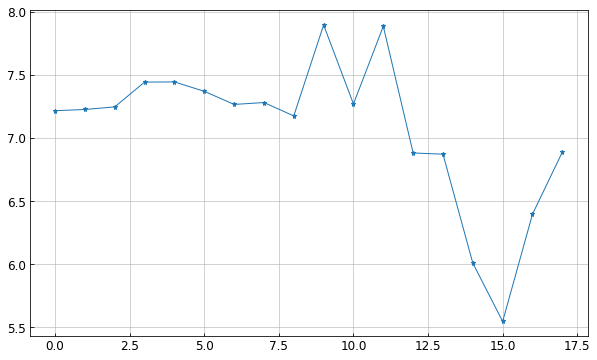

In [14]:
""" график температур посерийный """ 
plt.plot(table['T'], '-*');
plt.grid()

## 1. Учёт влияния температуры

### Вычитание теплового пьедестала

Определяем тепловой шум по измерениям с закрытой крышкой (серия номер 17).

Экспериментальные данные получены при напряжении питания ФЭУ -28.2В (ЦАП 250).
Кривая теплового шума f255() снята для напряжения -29.2В (ЦАП 255).

Приведем кривую к напряжению ЦАП 250, используя отношение токов при этих напряжениях: 35.2/41.2 = 0.8543 (Взято из записей Димы, нужно проверить этот коэффициент).  UPD: проверено, получен коэффициент 36.06/41.53=0.868 Подробности см. тут https://github.com/bonvech/Sphere/blob/master/Detector/2018_11_08_Voltage.ipynb

Экспериментальная точка теплового шума при ЦАП 250 лежит на кривой f250(), поэтому коррекция термометра не нужна. иначе бы вводилась коррекция на температуру вида a * np.exp(0.079*(x - 1.85)). Т.е. отпределялась бы поправка - на сколько градусов нужно сдвинуть измеренное значение температуры, чтобы кривая теплового шума f250() прошла через экспериментальные значения. (Поправка на температуру составляла бы -1.85 градуса, если бы речь шла об измерениях при  коде 255).

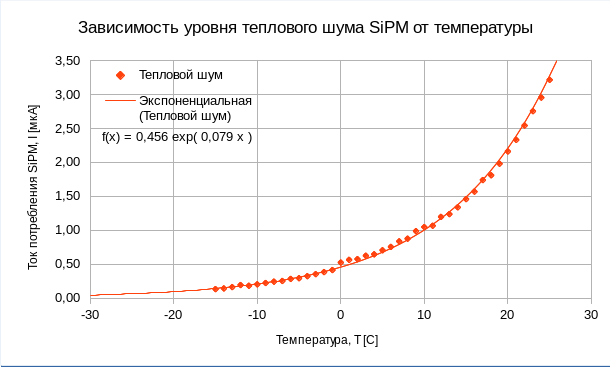

In [15]:
from IPython.display import Image 
Image("SiPM_AT.png", embed=True)

In [17]:
## тепловой шум для напряжения V = 29.2B, DAC = 255
def f255(x):
    return 0.456 * np.exp(0.079*(x))

## тепловой шум для напряжения V = 28.8B, DAC = 250
def f250(x):
    return f255(x) * 0.868   #0.85436  ## 35.2/41.2 = 0.8543689

## тепловой шум для напряжения V = 29.2B, DAC = 255 с поправкой датчика температуры
def f(x):
    return 0.456 * np.exp(0.079*(x - 1.85))

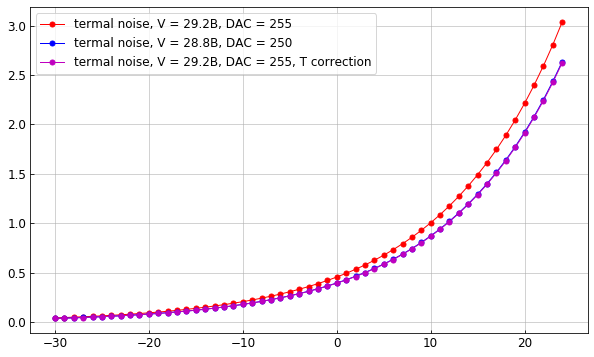

In [18]:
x = [x for x in range(-30,25,1)]
y = [f255(i) for i in x]
plt.plot(x,y,'r-o', label = "termal noise, V = 29.2B, DAC = 255")
y = [f250(i) for i in x]
plt.plot(x,y,'b-o', label = "termal noise, V = 28.8B, DAC = 250")
y = [f(i) for i in x]
plt.plot(x,y,'m-o', label = "termal noise, V = 29.2B, DAC = 255, T correction")

plt.legend()
plt.grid()

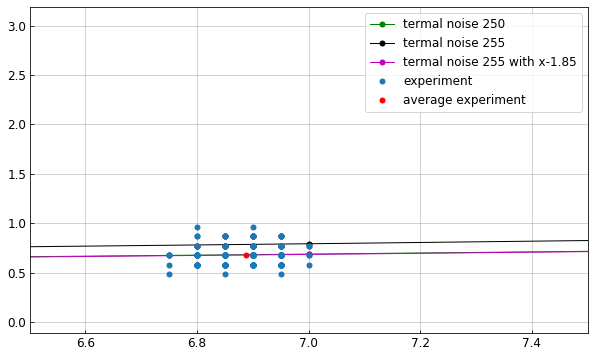

In [19]:
## для серии номер 17 - с закрытыми крышками - проверяем правильность термометра 
i = 17
part=data[(data.time >= table.begin[i]) & (data.time <= table.end[i])]

x = [x for x in range(-30,25,1)]
y = [f250(i) for i in x]
plt.plot(x,y,'g-o', label = "termal noise 250")

y = [f255(i) for i in x]
plt.plot(x,y,'k-o', label = "termal noise 255")

y = [f(i) for i in x]
plt.plot(x,y,'m-o', label = "termal noise 255 with x-1.85")

plt.plot(part['T'], part['I'], 'o', label = "experiment")
plt.plot(part['T'].mean(), part['I'].mean(), 'ro', label = "average experiment")
plt.xlim(6.5, 7.5)
plt.legend()
plt.grid()

### Вычитание теплового пьедестала.

    Берем тепловой шум (токовый пьедестал) из формулы f250() для кода напряжения 250 и вычитаем его из измереннного значения тока I.

In [20]:
data['In'] = data['I'] - f250(data['T'])

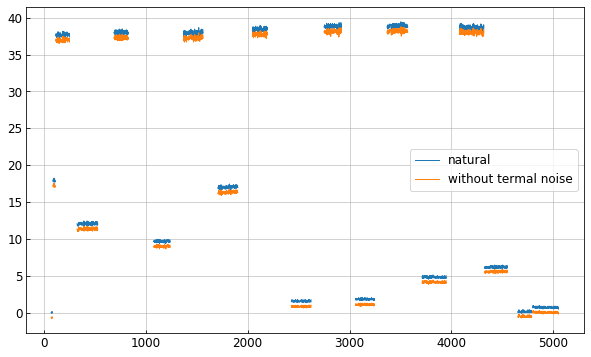

In [21]:
"""   токи во всех сериях с поправками и без  """
plt.plot(data['I'],  label = 'natural')
plt.plot(data['In'], label = 'without termal noise')
plt.legend()
plt.grid()

## 2. Засветка от ночного неба без фильтров

In [22]:
''' данные без фильтра соберем отдельно в датафрейм nofilter  '''
nofilter = pd.DataFrame()
time_mean = []
cur_mean = []

for i in range(table.shape[0]-3):
    part = data[(data.time >= table.begin[i]) & (data.time <= table.end[i])]
    ## count mean current
    n = table.loc[i, 'count']
    table.loc[i,'In'] = part.In.mean()
    ## count mean time
    table.loc[i,'tmean'] = part.time.loc[part.time.index[0]+n//2]
    
    ## выделим данные при w 250 и без фильтров в датафрейм nofilter
    if (table.name[i] != 'Без_фильтров') or (table.w[i] != 250):        
        continue

    #part['timestamp'] = part.date +' ' + part.time
    #part['xtime']     = [dt.datetime.strptime(i, '%d.%m.%Y %H:%M:%S') for i in part.timestamp]
         
    nofilter = pd.concat([nofilter, part])
    cur_mean.append( part.In.mean())
    time_mean.append(part.time.loc[part.time.index[0]+n//2] )
    table.loc[i,'I0'] = part.In.mean()
    print(i, n, part.shape, part.time.loc[part.time.index[0]+n//2] )
     
print(nofilter.shape)
#nofilter.head()

2 136 (136, 11) 21:43:55
4 134 (134, 11) 21:57:32
6 187 (187, 11) 22:09:16
8 144 (144, 11) 22:19:57
10 164 (164, 11) 22:31:43
12 199 (199, 11) 22:42:08
14 232 (232, 11) 22:54:12
(1196, 11)


In [23]:
''' для данных с фильтрами оценим средний ток светового фона как среднее между соседними измерениями без фильтра '''
cur_filter_mean = []
time_filter_mean = []

for i in range(table.shape[0]-1):
    if (table.name[i] != 'Без_фильтров') and (table.w[i] == 250):   
        cur = 0.5 * (table.In[i-1] + table.In[i+1])
        table.loc[i,'I0'] = cur
        cur_filter_mean.append(cur)
        time_filter_mean.append(table.tmean[i])
time_filter_mean

['21:52:12', '22:04:09', '22:14:46', '22:26:40', '22:36:54', '22:48:04']

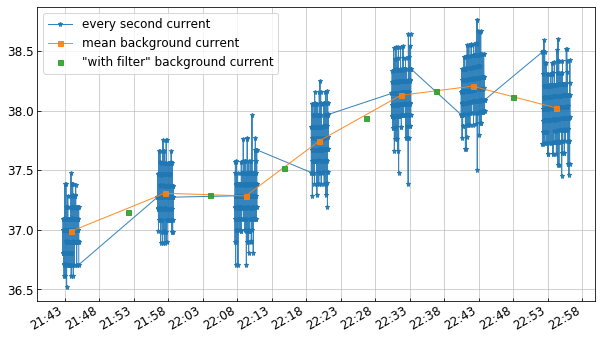

In [24]:
""" световой фон  - токи в измерениях без фильтра """
fig, ax = plt.subplots()

xx = [dt.datetime.strptime(i, '%H:%M:%S') for i in nofilter.time]
ax.plot(xx, nofilter.In, '-*', alpha=0.9, label = 'every second current')

xxx = [dt.datetime.strptime(i, '%H:%M:%S') for i in time_mean]
ax.plot(xxx, cur_mean, '-s', alpha=0.9, label = 'mean background current')

xxf = [dt.datetime.strptime(i, '%H:%M:%S') for i in time_filter_mean]
ax.plot(xxf, cur_filter_mean, 's', alpha=0.9, label = '\"with filter\" background current')

ax.xaxis.set_major_locator(dates.MinuteLocator(interval=5))  # <--- NOTE!
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
fig.autofmt_xdate()
plt.legend()
plt.grid()

4 689 827 21:56:27 21:58:45


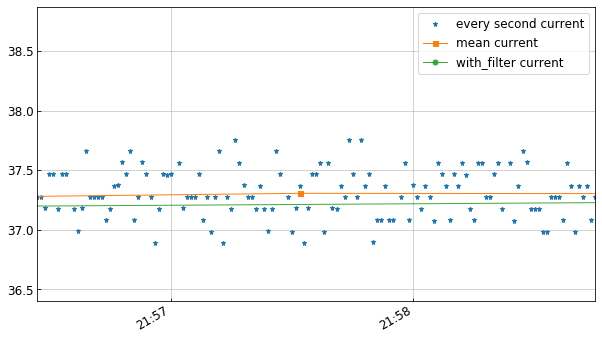

In [25]:
""" ток в одной серии измерений без фильтра практически постоянный  """
fig, ax = plt.subplots()

xx = [dt.datetime.strptime(i, '%H:%M:%S') for i in nofilter.time]
ax.plot(xx, nofilter.In, '*', label = 'every second current')

xxx = [dt.datetime.strptime(i, '%H:%M:%S') for i in time_mean]
ax.plot(xxx, cur_mean, '-s',  label = 'mean current')

xxf = [dt.datetime.strptime(i, '%H:%M:%S') for i in time_filter_mean]
ax.plot(xxf, cur_filter_mean, '-o', alpha=0.9, label = 'with_filter current')

ax.xaxis.set_major_locator(dates.MinuteLocator(interval=1))  # <--- NOTE!
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

i = 4
tmin = int(table.index0[i])
tmax = int(table.index1[i])
print(i, tmin, tmax, nofilter.time.loc[tmin], nofilter.time.loc[tmax],)
xmin = dt.datetime.strptime(nofilter.time.loc[tmin], '%H:%M:%S')
xmax = dt.datetime.strptime(nofilter.time.loc[tmax], '%H:%M:%S')

#tmin = 270  ##136
#tmax = 456  ##269
#xmin = dt.datetime.strptime(nofilter.time.loc[nofilter.time.index[tmin]], '%H:%M:%S')
#xmax = dt.datetime.strptime(nofilter.time.loc[nofilter.time.index[tmax]], '%H:%M:%S')
plt.xlim(xmin, xmax)
fig.autofmt_xdate()
plt.legend()
plt.grid()

## 3. Определение коэффициентов поглощения светофильтров 

Коэффициент поглощения определяется как отношение тока со светофильтром In к току без светофильтра I0.

In [26]:
## относительная ошибка измерения тока
table['Irel'] = table.Istd / table.In
## коэффициент ослабления светофильтра
table['K_abs'] = table.In / table.I0
## относительная ошибка коэффициента
table['Kstd'] = 1.4 * table['K_abs'] * table.Irel

In [28]:
table[['name','count','In','Istd','Irel','I0','K_abs', 'Kstd']][2:15]

,name,count,In,Istd,Irel,I0,K_abs,Kstd
2,Без_фильтров,136,36.986853,0.200830,0.005430,36.986853,1.000000,0.007602
3,УФС-1,199,11.343004,0.144973,0.012781,37.146748,0.305357,0.005464
4,Без_фильтров,134,37.306643,0.201319,0.005396,37.306643,1.000000,0.007555
5,УФС-5,157,8.978323,0.128502,0.014312,37.295438,0.240735,0.004824
6,Без_фильтров,187,37.284234,0.216050,0.005795,37.284234,1.000000,0.008113
7,ФС6_(BG3),190,16.332254,0.150788,0.009233,37.515722,0.435344,0.005627
8,Без_фильтров,144,37.747210,0.217986,0.005775,37.747210,1.000000,0.008085
9,SL360/50,189,0.810220,0.091476,0.112903,37.938010,0.021356,0.003376
10,Без_фильтров,164,38.128810,0.213022,0.005587,38.128810,1.000000,0.007822
11,SL280-380,182,1.076993,0.091318,0.084790,38.167330,0.028218,0.003350


# Результат: Коэффициенты поглощения фильтров

In [29]:
for i in range(3,14,2):
    print('%15s:  %.3f +- %.3f' %( table.name[i], table.K_abs[i], table.Kstd[i] ))

          УФС-1:  0.305 +- 0.005
          УФС-5:  0.241 +- 0.005
      ФС6_(BG3):  0.435 +- 0.006
       SL360/50:  0.021 +- 0.003
      SL280-380:  0.028 +- 0.003
   FF01-375/110:  0.108 +- 0.004


In [30]:
table.to_csv("Filters_results.csv")